# Figure 7

## Caption
Cross plot of cumulative stress days and phosphorus load for each river. Color represents the region the river lies in (See Figure 1). Outline color represents the month cumulative stress days is calculated for: light gray is June, medium gray is July, and black is August. The area of the circle displays the population of the county at the mouth of each river based on the 2010 census. The inset magnifies the tributaries with small loads. 

In [1]:
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42

import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from matplotlib.ticker import AutoMinorLocator

from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.patches import PathPatch

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from mpl_toolkits.axes_grid.inset_locator import InsetPosition

import cmocean
import seaborn as sns

from cartopy.io.shapereader import Reader

#sns.set_style("whitegrid")
#sns.set_style("ticks")
#sns.set_context("paper")

/Users/gloege/anaconda3/envs/cartopy/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: The mpl_toolkits.axes_grid module was deprecated in version 2.1. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist provies the same functionality instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/gloege/anaconda3/envs/cartopy/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


# Load Data

In [2]:
### define directories
dir_raw = '/Users/gloege/Documents/Projects/MITgcm-Michigan-Phosphorus/data/raw/'
dir_clean = '/Users/gloege/Documents/Projects/MITgcm-Michigan-Phosphorus/data/clean/'

In [3]:
### Get Loading
df_wrtds = pd.read_csv(f'{dir_raw}wrtds_pload_2007_2010_MTyr.csv', index_col='river')
df_wrtds = df_wrtds.rename({'Pere Marquette':'Pere_Marquette', 'St Joseph':'St_Joseph'})

ds_csd = xr.open_dataset(f'{dir_clean}cumulative_stress_days_all_rivers_JJA.nc')

In [4]:
### County level population
pop = pd.read_csv(f'{dir_raw}co-est2017-alldata.csv',
                  index_col=None, 
                  header=0, 
                  encoding = "ISO-8859-1")

### "pop" out counties in WI and MI
### if my model used rivers in IN and IL I would pop those states out as well
pop = pop[['STNAME','CTYNAME','CENSUS2010POP']].loc[(pop['STNAME']=='Wisconsin') | 
                                                    (pop['STNAME']=='Michigan')]

### Dictionary of 
river_pop = {'Manistique':pop['CENSUS2010POP'].loc[(pop['STNAME']=='Michigan') &  
                         (pop['CTYNAME']=='Schoolcraft County')].values, 
                  'Kalamazoo':pop['CENSUS2010POP'].loc[(pop['STNAME']=='Michigan') &  
                         (pop['CTYNAME']=='Allegan County')].values,  
                  'Manistee':pop['CENSUS2010POP'].loc[(pop['STNAME']=='Michigan') &  
                         (pop['CTYNAME']=='Manistee County')].values, 
                  'Fox':pop['CENSUS2010POP'].loc[(pop['STNAME']=='Wisconsin') &  
                         (pop['CTYNAME']=='Brown County')].values, 
                  'Milwaukee':pop['CENSUS2010POP'].loc[(pop['STNAME']=='Wisconsin') &  
                         (pop['CTYNAME']=='Milwaukee County')].values,  
                  'Sheboygan':pop['CENSUS2010POP'].loc[(pop['STNAME']=='Wisconsin') &  
                         (pop['CTYNAME']=='Sheboygan County')].values,  
                  'Muskegon':pop['CENSUS2010POP'].loc[(pop['STNAME']=='Michigan') &  
                         (pop['CTYNAME']=='Muskegon County')].values,  
                  'St_Joseph':pop['CENSUS2010POP'].loc[(pop['STNAME']=='Michigan') &  
                         (pop['CTYNAME']=='Berrien County')].values,  
                  'Menominee':pop['CENSUS2010POP'].loc[(pop['STNAME']=='Michigan') &  
                         (pop['CTYNAME']=='Menominee County')].values,  
                  'Grand':pop['CENSUS2010POP'].loc[(pop['STNAME']=='Michigan') &  
                         (pop['CTYNAME']=='Ottawa County')].values,  
                  'Pere_Marquette':pop['CENSUS2010POP'].loc[(pop['STNAME']=='Michigan') &  
                         (pop['CTYNAME']=='Mason County')].values,
                    '10k':   10000,
                    '25k':   25000,
                    '50k':   50000,
                    '100k': 100000,
                    '200k': 200000,
                    '500k': 500000,
                    '1000k': 1000000}

# Generate Figure

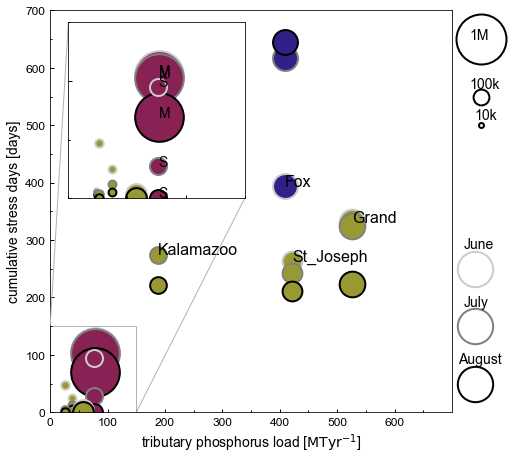

In [5]:
fig = plt.figure(figsize=(7.2, 11))
ax = fig.add_subplot(111)

### Rivers
rivers = ['Manistique', 'Kalamazoo', 'Manistee', 'Fox', 'Milwaukee', 
          'Sheboygan','Muskegon', 'St_Joseph', 'Grand', 'Pere_Marquette']

### Print these rivers 
print_rivers = ['Kalamazoo','Fox','St_Joseph','Grand']

### Regions 
regions = {'north': ['Fox','Menominee','Manistique'],
           'east': ['Manistee','Pere_Marquette','Muskegon',
                    'Grand' ,'Kalamazoo', 'St_Joseph'],
           'west':['Milwaukee', 'Sheboygan']}

### Define region colors 
coln = list(map(lambda x: x/255, [51, 31, 136]))
cole = list(map(lambda x: x/255, [153, 153, 51]))
colw = list(map(lambda x: x/255, [136, 34, 85]))

### Plot load vs CSD
for riv in rivers:
    for mon in ['june', 'july', 'august']:
        color=coln if(riv in regions['north']) else \
              cole if (riv in regions['east']) else \
              colw if (riv in regions['west']) else 0

        ax.scatter(df_wrtds.mean(axis=1)[riv], 
                   ds_csd[riv].where(ds_csd['months']==mon, drop=True).values,
                    c=color,
                    edgecolors=[0.8,0.8,0.8] if mon=='june' else \
                   [0.5,0.5,0.5] if mon=='july' else \
                   [0,0,0] if mon=='august' else 0,
                    linewidths=2,
                    s=river_pop[riv]/400)
        
        if (riv in print_rivers) and (mon=='june'):
            ax.text(df_wrtds.mean(axis=1)[riv], 
                    ds_csd[riv].where(ds_csd['months']==mon, drop=True).values, 
                    riv,
                    fontsize=16)
            
### Month references 
ax.scatter(740, 250,
           c=[1,1,1],
           edgecolors=[0.8,0.8,0.8],
            linewidths=2,
           s=1250, 
           clip_on=False)
ax.scatter(740, 150,
           c=[1,1,1],
           edgecolors=[0.5,0.5,0.5],
            linewidths=2,
           s=1250,
           clip_on=False)
ax.scatter(740, 50,
           c=[1,1,1],
           edgecolors=[0,0,0],
            linewidths=2,
           s=1250,
           clip_on=False)

ax.text(720, 285, 'June', fontsize=14)
ax.text(720, 185, 'July', fontsize=14)
ax.text(710, 85, 'August', fontsize=14)

### pop reference
ax.scatter(750, 500,
           c=[1,1,1],
           edgecolors=[0,0,0],
            linewidths=2,
           s=river_pop['10k']/400, 
           clip_on=False)
ax.scatter(750, 550,
           c=[1,1,1],
           edgecolors=[0,0,0],
            linewidths=2,
           s=river_pop['100k']/400,
           clip_on=False)
ax.scatter(750, 650,
           c=[1,1,1],
           edgecolors=[0,0,0],
            linewidths=2,
           s=river_pop['1000k']/400,
           clip_on=False)



ax.text(740, 510, '10k', fontsize=14)
ax.text(730, 565, '100k', fontsize=14)
ax.text(730, 650, '1M', fontsize=14)

### X and Y limit
ax.set_xlim(0, 700)
ax.set_xticks(np.arange(0, 650, 100))
ax.set_ylim(0, 700)
ax.set_yticks(np.arange(0, 800, 100))

### Axis labels
ax.set_xlabel(r'tributary phosphorus load [$\rm MT yr^{-1}$]', fontsize=14)
ax.set_ylabel(r'cumulative stress days [days]', fontsize=14)

### Make Square
x0,x1 = ax.get_xlim()
y0,y1 = ax.get_ylim()
ax.set_aspect(abs(x1-x0)/abs(y1-y0))
ax.get_position().bounds

# Ticks
ax.tick_params(axis='both', 
               which='both', 
               direction='in', 
               width=1, 
               color='k', 
               pad=5, 
               labelsize=12)
### minor ticks
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.yaxis.set_minor_locator(AutoMinorLocator(2))

#############################################
#
# INSET FIGURE
#
#############################################
# These are in unitless percentages of the figure size. (0,0 is bottom left)
#left, bottom, width, height = [0.2, 0.49, 0.36, 0.36]
# These are in unitless percentages of the figure size. (0,0 is bottom left)
left, bottom, width, height = [.16, 0.46, 0.34, 0.34]
ax2 = fig.add_axes([left, bottom, width, height])

# Mark the region corresponding to the inset axes on ax1 and draw lines
# in grey linking the two axes.
mark_inset(ax, ax2, loc1=2, loc2=4, fc="none", ec='0.7')

### Plot load vs CSD
for riv in rivers:
    for mon in ['june', 'july', 'august']:
        color=coln if(riv in regions['north']) else \
              cole if (riv in regions['east']) else \
              colw if (riv in regions['west']) else 0

        ax2.scatter(df_wrtds.mean(axis=1)[riv], 
                   ds_csd[riv].where(ds_csd['months']==mon, drop=True).values,
                    c=color,
                    edgecolors=[0.8,0.8,0.8] if mon=='june' else \
                   [0.5,0.5,0.5] if mon=='july' else \
                   [0,0,0] if mon=='august' else 0,
                    linewidths=2,
                    s=river_pop[riv]/400)
        
        if (riv in ['Milwaukee']):
            ax2.text(df_wrtds.mean(axis=1)[riv], 
                    ds_csd[riv].where(ds_csd['months']==mon, drop=True).values, 
                    'M',
                    fontsize=14)
            
        if (riv in ['Sheboygan']):
            ax2.text(df_wrtds.mean(axis=1)[riv], 
                    ds_csd[riv].where(ds_csd['months']==mon, drop=True).values, 
                    'S',
                    fontsize=14)

### X and Y limit
ax2.set_xlim(0, 150)
ax2.set_xticks(np.arange(0, 150, 100))
ax2.set_ylim(0, 150)
ax2.set_yticks(np.arange(0, 150, 100))
ax2.set_yticklabels([])
ax2.set_xticklabels([])

### Make Square
x0,x1 = ax2.get_xlim()
y0,y1 = ax2.get_ylim()
ax2.set_aspect(abs(x1-x0)/abs(y1-y0))
ax2.get_position().bounds

# Ticks
ax2.tick_params(axis='both', 
               which='both', 
               direction='in', 
               width=1, 
               color='k', 
               pad=5, 
               labelsize=12)
### minor ticks
ax2.xaxis.set_minor_locator(AutoMinorLocator(2))
ax2.yaxis.set_minor_locator(AutoMinorLocator(2))